## Initialize Models

In [2]:
from slf_dataset import SLFDataset1bit, DEFAULT_ROOT
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io
import torch.nn as nn
import os
import sys

# import model classes
sys.path.append('/scratch/sagar/Projects/matlab/radio_map_deep_prior/deep_prior')
from networks.ae import Autoencoder, AutoencoderSelu
from networks.gan import Generator, Generator256, Generator512

MAP_ROOT = '/scratch/sagar/slf/train_set/map_set_torch_raw_unnormalized'
SLF_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

train_set_slf = SLFDataset1bit(root_dir=os.path.join(SLF_ROOT, 'slf_mat'), 
                    csv_file=os.path.join(SLF_ROOT, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])

train_set_map = SLFDataset1bit(root_dir=os.path.join(MAP_ROOT, 'slf_mat'), 
                    csv_file=os.path.join(SLF_ROOT, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])


SLF_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/1bit_slf_1.model'
MAP_MODEL_PATH = '/nfs/stak/users/shressag/sagar/deep_completion/deep_slf/models/full_data_models/1bit_map_1.model'


map_network = AutoencoderSelu()
checkpoint = torch.load(MAP_MODEL_PATH)
map_network.load_state_dict(checkpoint['model_state_dict'])
map_network.eval()

slf_network = AutoencoderSelu()
checkpoint = torch.load(SLF_MODEL_PATH)
slf_network.load_state_dict(checkpoint['model_state_dict'])
slf_network.eval()

generator = Generator256()
GAN_PATH = '/home/sagar/Projects/matlab/quantized_spectrum_cartography/deep_prior/trained_models/gan/sngan11_256_unnorm'
GAN_PATH_SERVER = '/scratch/sagar/Projects/matlab/quantized_spectrum_cartography/deep_prior/trained_models/gan/sngan11_256_unnorm'

try:
    checkpoint = torch.load(GAN_PATH, map_location=torch.device('cpu'))
except:
    checkpoint = torch.load(GAN_PATH_SERVER, map_location=torch.device('cpu'))
    
generator.load_state_dict(checkpoint['g_model_state_dict'])
generator.eval()

Generator256(
  (main): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(16, 2, kernel_size=(4, 4), stride=(2, 2))
    (14): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15

## Visualize map completion

Text(0.5, 1.0, 'true map')

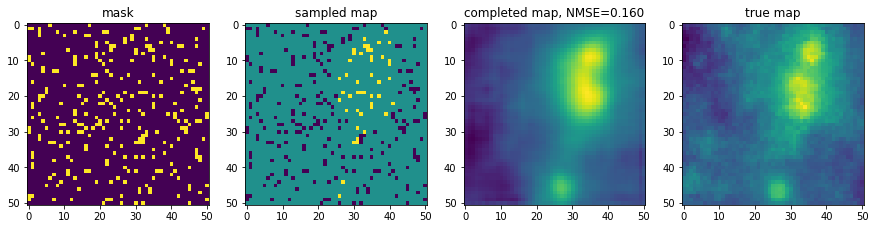

In [8]:
a,b = train_set_map[1]
map_complete = map_network(a.unsqueeze(dim=0))

fig, axes = plt.subplots(1,4, figsize=(15, 15))
axes[0].imshow(a[0].squeeze().numpy())
axes[0].set_title("mask")
axes[1].imshow(a[1].squeeze().numpy())
axes[1].set_title("sampled map")
axes[2].imshow(torch.log(map_complete).squeeze().detach().numpy())

NMSE = torch.norm(map_complete-b)**2/torch.norm(b)**2
axes[2].set_title("completed map, NMSE={:.3f}".format(NMSE))

axes[3].imshow(torch.log(b).squeeze().detach().numpy())
axes[3].set_title("true map")


## Visualize slf completion

Text(0.5, 1.0, 'true SLF')

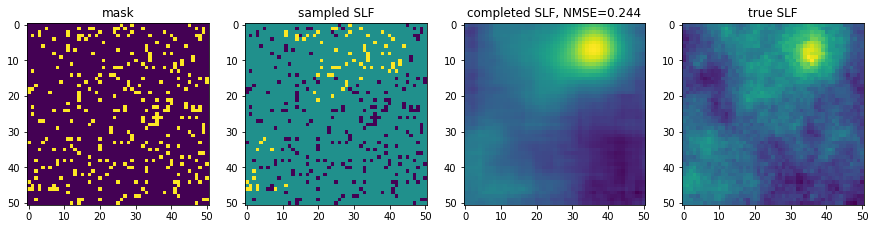

In [9]:
a,b = train_set_slf[4]
slf_complete = slf_network(a.unsqueeze(dim=0))

fig, axes = plt.subplots(1,4, figsize=(15, 15))
axes[0].imshow(a[0].squeeze().numpy())
axes[0].set_title("mask")
axes[1].imshow(a[1].squeeze().numpy())
axes[1].set_title("sampled SLF")
axes[2].imshow(torch.log(slf_complete).squeeze().detach().numpy())
NMSE = torch.norm(slf_complete-b)**2/torch.norm(b)**2

axes[2].set_title("completed SLF, NMSE={:.3f}".format(NMSE))
axes[3].imshow(torch.log(b).squeeze().detach().numpy())
axes[3].set_title("true SLF")

## Optimization

In [2]:
from IPython.display import clear_output
import time
from scipy.stats import norm
from torch.distributions import normal

max_iter = 100
loop_count = 50
z_dimension = 256
criterion = nn.MSELoss()
lambda_reg = 1e-4

def F(y):
    return 1/(1+torch.exp(-y))
    
def dither(y):
    F_y = F(y)
    return torch.bernoulli(F_y)

def F_probit(y, std):
    return (1/2)*(1 + torch.erf(y/(std*1.414213)))

# def dither_probit_old(y, std):
#     epsilon = np.random.randn(1)
#     return 1 if (y+std*epsilon>=0) else 0

def dither_probit(y, std):
    F_y = F_probit(y, std)
    return torch.bernoulli(F_y)

class BaleviLoss(torch.nn.Module):
    """
    
    """
    def __init__(self, lambda_reg = 0.5):
        super(BaleviLoss, self).__init__()
        self.lambda_reg = lambda_reg
        
    def forward(self, y_hat, y_target):
        quant_loss = -self.lambda_reg*((y_target*y_hat).sum())
        return quant_loss

def outer(mat, vec):
    prod = torch.zeros(( *vec.shape,*mat.shape), dtype=torch.float32)
    for i in range(len(vec)):
        prod[i,:,:] = mat*vec[i]
    return prod

def get_tensor(S, C):
    prod = 0
    for i in range(C.shape[0]):
        prod += outer(S[i,0,:,:], C[i,:])
    return prod

def NMSE(T, T_target):
    return torch.norm(T-T_target, 'fro')

class DeterministicCost(torch.nn.Module):
    """
    
    """
    def __init__(self, mean=0):
        super(DeterministicCost, self).__init__()
        self.lambda_reg = 0.001
        self.mean = mean
        
    def forward(self, S, C, T_target):
        T_hat = get_tensor(S,C)
        T_hat = T_hat-self.mean
        quant_loss = - self.lambda_reg*((T_hat*T_target).sum()) + torch.norm(T_hat, 'fro')
        return quant_loss

class ProbitLoss(torch.nn.Module):
    """
    
    """
    def __init__(self, mean=0, std = 1):
        super(ProbitLoss, self).__init__()
        
    def forward(self, S, C, T_target):
        quant_loss = -((get_tensor(S,C)*T_target).sum())
        return quant_loss

def init_z(generator, slf_target):
    z = torch.randn((1,z_dimension), dtype=torch.float32, )
    criterion = nn.MSELoss()
    
    # First select a good random vector
    min_criterion = 9999999
    for i in range(200):
        temp = torch.randn((1,z_dimension), dtype=torch.float32)
        slf_out = generator(temp)
       
        temp_criterion = criterion(slf_out, slf_target) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_first', min_criterion.item())

    for i in range(200):
        temp = 0.2*torch.randn((1,z_dimension), dtype=torch.float32) + z
        slf_out = generator(temp)
            
        temp_criterion = criterion(slf_out, slf_target) 
        if  temp_criterion < min_criterion:
            z.data = temp.clone()
            min_criterion = temp_criterion
            print('min_second', min_criterion.item())

    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=0.01)
    
    num_iter = 0
    loss_prev = 999999
    loss_current = 999
    while num_iter < max_iter: #and (loss_prev - loss_current > loss_change_threshold):
        loss_prev = loss_current
        optimizer.zero_grad()
        
        gen_out = generator(z)
        
        loss = criterion(gen_out, slf_target)
        
        loss.backward()
        optimizer.step()

        loss_current = loss.item()
        num_iter += 1
    return z
    
def S_optimize(generator, T_quant, mean, Z, C, loss_criterion='bce', print_out=False, true=None, z_dimension=256, lr=0.01):

    if loss_criterion == 'balevi':
        criterion = DeterministicCost()
        loss_change_threshold = 0.0001
    elif loss_criterion == 'bce':
        criterion = nn.BCELoss()
        loss_change_threshold = 0.0000001

    z.requires_grad = True
    optimizer = torch.optim.Adam([Z], lr=0.01)
    
    num_iter = 0
    loss_prev = 999999
    loss_current = 999
    while num_iter < max_iter: #and (loss_prev - loss_current > loss_change_threshold):
        print(loss_prev-loss_current)
        loss_prev = loss_current
        optimizer.zero_grad()
        
        gen_out = generator(Z)
        
        if loss_criterion == 'bce':
#             S_hat = F(S_hat) 
            T_hat = get_tensor(S_hat, C)
            T_hat = T_hat - mean
            loss = criterion(T_hat, T_quant)
        else:
            loss = criterion(S_hat, C, T_quant)
        
        loss.backward()
        optimizer.step()

        loss_current = loss.item()
        num_iter += 1
    return Z

In [1]:
import scipy.io as sio
from params import mean_slf
data = sio.loadmat('data/onebitdata')

f = 0.5
std_probit = 0.008
# stds_probit = [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.01, 0.02, 0.04]
stds_probit = [0.008]
nmse_list = []

loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'

S = torch.from_numpy(data['S']).type(torch.float32)
T = torch.from_numpy(data['T']).type(torch.float32)
C = torch.from_numpy(data['C']).type(torch.float32)
S_true = torch.from_numpy(data['S_true']).type(torch.float32)
C_true = torch.from_numpy(data['C_true']).type(torch.float32)
T_true = torch.from_numpy(data['T_true']).type(torch.float32)

Om = torch.from_numpy(data['Om']).type(torch.float32)

T = T.permute(2,0,1)
T_true = T_true.permute(2,0,1)
S = S.permute(2,0,1)
S_true = S_true.permute(2,0,1)
C = C.permute(1,0)
C_true = C_true.permute(1,0)

W = Om.unsqueeze(dim=0)
W = W.unsqueeze(dim=0)
Wx = W.repeat(64,1,1,1)

T_old = T.clone()
S_old = S.clone()



ModuleNotFoundError: No module named 'params'

In [4]:
maxIter = 100
R,I,J = S.shape
K = 64
Z_init = torch.zeros((R, z_dimension), dtype=torch.float32)
Z = torch.zeros((R, z_dimension), dtype=torch.float32)
lambda_c = 0.0001
lambda_s = 0

if loss_model=='sigmoid':
    T = T_true-mean_slf
    T = dither(T)
elif loss_model=='probit':
    T = T_true-mean_slf
    T = dither_probit(T, std_probit)
elif loss_model =='determ':
    pass

S_init = S.clone()
C_init = C.clone()
S_init = S_init.unsqueeze(dim=1)
T = T.unsqueeze(dim=1)

# init Z
for r in range(R):
    Z_init[r,:] = init_z(generator, S)
    
for std_probit in stds_probit:
    S = S_init.clone()
    C = C_init.clone()
    Z = Z_init.clone()
    

    Z = Z.detach().clone()
    C.requires_grad = True
    Z.requires_grad = True

    optimizerC = torch.optim.Adam([C], lr=0.01)
    optimizerZ = torch.optim.Adam([Z], lr=0.01)

    if loss_model=='probit' or loss_model=='sigmoid':
        criterion = nn.BCELoss()
    else:
        criterion = DeterministicCost(mean = mean_slf)

    with torch.no_grad():
        S = generator(Z)

    costs = []
    nmses = []
    for i in range(maxIter):
        
        # C optimization
        
        S = generator(Z)
        Sc = S.detach().clone()
        optimizerC.zero_grad()

        if loss_model=='sigmoid':
            T_hat = get_tensor(Sc, C)
            T_hat = T_hat.unsqueeze(dim=1)
            T_hat = T_hat - mean_slf
            T_hat = F(T_hat)
            cost = criterion(T_hat, T) + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        elif loss_model=='probit':
            T_hat = get_tensor(Sc, C)
            T_hat = T_hat.unsqueeze(dim=1)
            T_hat = T_hat - mean_slf
            T_hat = F_probit(T_hat, std_probit)
            cost = criterion(T_hat, T) + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        else:
            cost = criterion(Sc,C,T)
        
        cost.backward()
        optimizerC.step()
        with torch.no_grad():
            C[C<0] = 0

        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses.append(true_loss)
        # S optimization
        optimizerZ.zero_grad()
        S = generator(Z)
        if loss_model=='sigmoid':
            T_hat = get_tensor(Sc, C)
            T_hat = T_hat.unsqueeze(dim=1)
            T_hat = T_hat - mean_slf
            T_hat = F(T_hat)
            cost = criterion(T_hat, T) + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        elif loss_model=='probit':
            T_hat = get_tensor(Sc, C)
            T_hat = T_hat.unsqueeze(dim=1)
            T_hat = T_hat - mean_slf
            T_hat = F_probit(T_hat, std_probit)
            cost = criterion(T_hat, T) + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        else:
            cost = criterion(S, C, T)
        cost.backward()
        optimizerZ.step()

        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses.append(true_loss)
        costs.append(cost)
        print('cost: {}, nmse: {}'.format(cost, true_loss))
    print('ended {}'.format(std_probit))
    nmse_list.append(true_loss)

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2, 51, 51])) that is different to the input size (torch.Size([1, 1, 51, 51])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


min_first 0.0013725762255489826
min_first 0.0008243745542131364
min_first 0.0007305672043003142
min_first 0.000711392262019217
min_first 0.000672784517519176
min_first 0.0006700385711155832
min_first 0.0003780451661441475
min_first 0.00033794905175454915
min_second 0.0003263036487624049
min_second 0.00031996346660889685
min_second 0.0003113420680165291
min_first 0.0007063830271363258
min_first 0.000379126489860937
min_first 0.0003733375924639404
min_first 0.0003697070060297847
min_second 0.0003681879607029259
min_second 0.00036817931686528027
min_second 0.0003660609945654869
min_second 0.0003578302566893399
min_second 0.0003383244329597801
min_second 0.00030529635841958225
cost: 0.6286855340003967, nmse: 1.265756607055664
cost: 0.6271799206733704, nmse: 1.2501909732818604
cost: 0.6267508864402771, nmse: 1.2361854314804077
cost: 0.6258760690689087, nmse: 1.2233209609985352
cost: 0.6230213642120361, nmse: 1.2112118005752563
cost: 0.622711181640625, nmse: 1.2003488540649414
cost: 0.621920

Text(0, 0.5, 'NMSE')

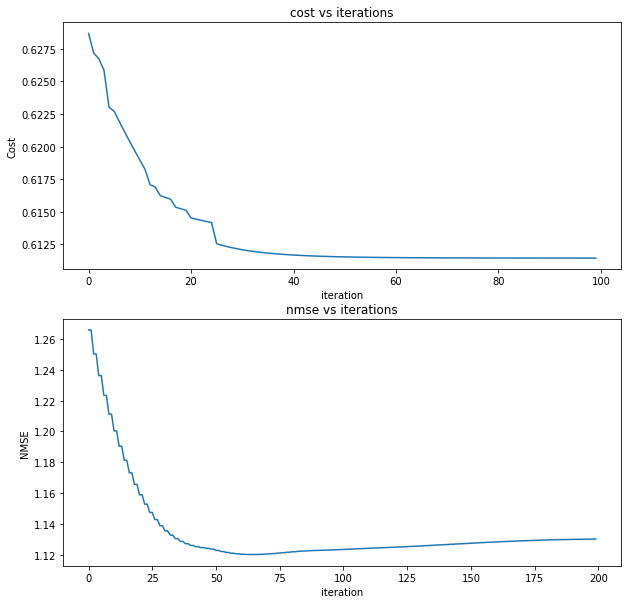

In [10]:
fig, axes = plt.subplots(2,1, figsize=(10,10))

axes[0].plot(np.arange(len(costs)), costs)
axes[0].set_title('cost vs iterations')
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('Cost')

axes[1].plot(np.arange(len(nmses)), nmses)
axes[1].set_title('nmse vs iterations')
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('NMSE')



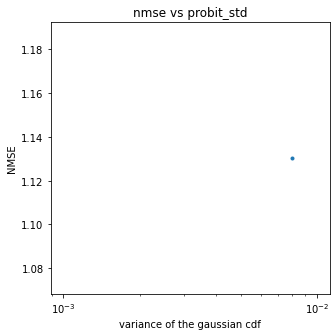

In [11]:
fig, axes = plt.subplots(1,1, figsize=(5,5))


axes.plot(stds_probit, nmse_list, marker='.')
axes.set_title('nmse vs probit_std')
axes.set_xlabel('variance of the gaussian cdf')
axes.set_ylabel('NMSE')
axes.set_xscale('log')

Text(0.5, 1.0, 'reconstructed slf')

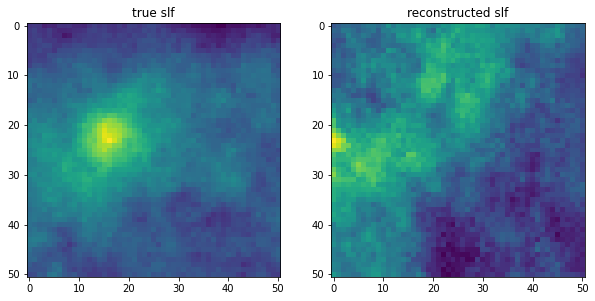

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(torch.log(S_true[1,:,:]).detach().numpy())
axes[0].set_title('true slf')


axes[1].imshow(torch.log(S[1,0,:,:]).detach().numpy())
axes[1].set_title('reconstructed slf')

Text(0.5, 1.0, 'reconstructed psd')

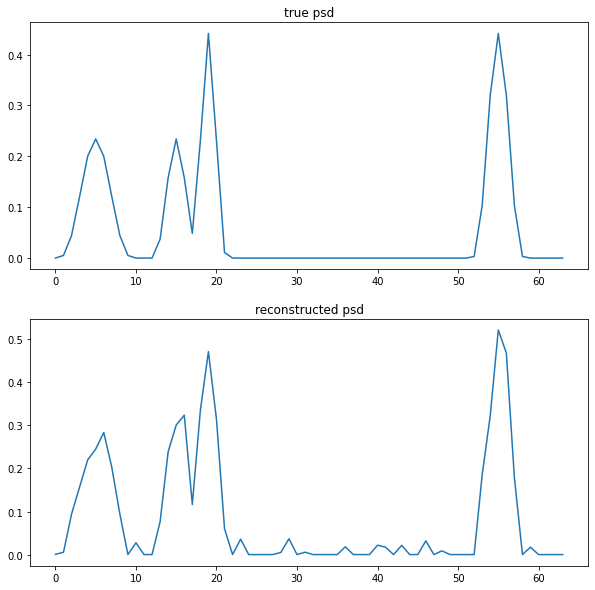

In [180]:
fig, axes = plt.subplots(2,1, figsize=(10,10))

axes[0].plot(np.arange(64), C_true[1,:].detach().numpy())
axes[0].set_title('true psd')


axes[1].plot(np.arange(64), C[1,:].detach().numpy())
axes[1].set_title('reconstructed psd')

Text(0.5, 1.0, 'input')

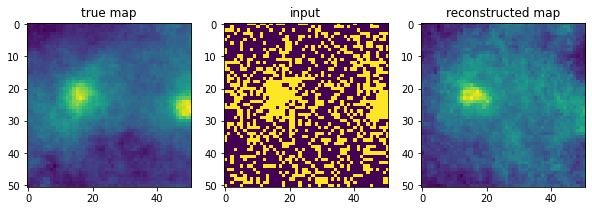

In [178]:
fig, axes = plt.subplots(1,3, figsize=(10,10))

axes[0].imshow(torch.log(T_true[5,:,:]).detach().numpy())
axes[0].set_title('true map')

Tr = get_tensor(S,C)
axes[2].imshow(torch.log(Tr[5,:,:]).detach().numpy())
axes[2].set_title('reconstructed map')

axes[1].imshow((T[5,0,:,:]).detach().numpy())
axes[1].set_title('input')


In [46]:
mean = -0.001

sum_loss_balevi = 0
sum_loss_bce = 0

for i in range(5):
    print(i)
    temp = torch.randn((1,32), dtype=torch.float32)
    y = generator(temp)
    y = y.detach()

    # quantize
    y_quant = y.clone()
    y_quant = y_quant-mean
    
    y_quant[y_quant>=mean] = 1
    y_quant[y_quant<mean] = -1
    method = 'balevi'
    y_hat = run_descent(generator, y_quant, mean, y, method,  print_out = True)
    actual_loss = torch.norm(y_hat-y)/torch.norm(y)
    sum_loss_balevi += actual_loss.item()
    
    y_quant = y.clone()
    y_quant = y_quant-mean
    
    y_quant = dither(y_quant)
    method = 'bce'
    y_hat = run_descent(generator, y_quant, mean, y, method,  print_out = True)
    actual_loss = torch.norm(y_hat-y)/torch.norm(y)
    sum_loss_bce += actual_loss.item()

loss_balevi = sum_loss_balevi/5
loss_bce = sum_loss_bce/5

out = run_descent(generator, y, mean, y_true, loss_criterion='bce', print_out=True, true=None, z_dimension=256, lr=0.01)


NameError: name 'y' is not defined

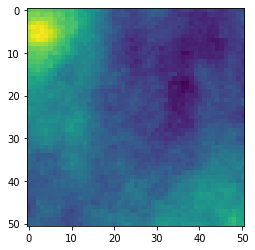

In [37]:
z = torch.randn((1,z_dimension), dtype=torch.float32)

out = generator(z)

out.shape

plt.imshow(torch.log(out.squeeze()).detach().numpy())

In [38]:
out.max()

tensor(0.2775, grad_fn=<MaxBackward1>)

In [40]:
out.min()

tensor(2.6011e-06, grad_fn=<MinBackward1>)

In [1]:
from tqdm import tqdm, trange
import csv
from slf_dataset import SLFDatasetMatTrue, SLFDataset1bit
import os
import torch
import csv

SRC = '/scratch/sagar/slf/train_set/one_bit/mat/'
TARGET = '/scratch/sagar/slf/train_set/one_bit/torch/'


train_set = SLFDatasetMatTrue(root_dir=os.path.join(SRC, 'slf_mat'), 
                    csv_file=os.path.join(SRC, 'details.csv'), raw_format=True, normalize=False)

# for i in trange(19000):
#     t = train_set[i]
#     filename = str(i)+'.pt'
#     filename = os.path.join(os.path.join(TARGET,'slf_mat'), filename)
#     torch.save(t, filename)

In [2]:
train_set_slf = SLFDataset1bit(root_dir=os.path.join(TARGET, 'slf_mat'), 
                    csv_file=os.path.join(TARGET, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])

In [7]:
a, t = train_set_slf[0]

AttributeError: 'tuple' object has no attribute 'shape'

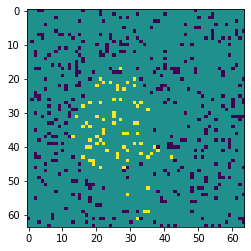

In [12]:
import matplotlib.pyplot as plt

plt.imshow((a[1]).squeeze().numpy())

In [17]:
a.shape

torch.Size([1, 64, 64])